# Code Submission : EE4708, Final Project

## Team Name : AccuracyBenders

## Team Members 1: Pruthvi Raj R G, EE17B114

## Team Members 2: Om Shri Prasath, EE17B113


Use the following [link](https://drive.google.com/file/d/11dzaueaeyHEwRCoYTmlynGav_XI1zn_x/view?usp=sharing) to download the models. It is best to use the notebook in the zip file itself while predicting on private dataset. Please make sure to reinstall the requirements in `requirements.txt` from the code to avoid compatibility issues.

In [1]:
import pandas as pd
import numpy as np
import pickle
import scipy.interpolate as interpolate
import glob
import cv2
from matplotlib import pyplot as plt
import random
import os
from sklearn.svm import SVC
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from scipy.ndimage.interpolation import shift
from skimage import io
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from skimage.util import random_noise
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Part 1 - Training Data Preprocessing

## Reading the Training Data

In [3]:
# Variables to store the image data
char_img = []
char_class = []

<IPython.core.display.Javascript object>

In [4]:
# List of files in training folder
characters = glob.glob("training/character_*")

<IPython.core.display.Javascript object>

In [5]:
# Iterating through each folder and reading all the images
for char in characters:
    char_type = int(char.split("_")[1])
    print("Reading character :", char_type)
    for i in glob.glob(char + "/*.csv"):
        data = pd.read_csv(i, header=None)
        char_img.append(data.values)
        char_class.append(char_type)

Reading character : 1
Reading character : 7
Reading character : 2
Reading character : 8
Reading character : 9
Reading character : 5
Reading character : 0
Reading character : 3
Reading character : 6
Reading character : 4


<IPython.core.display.Javascript object>

## Interpolation of Training Data

In [6]:
# Function to interpolate training data
def interpolate_img(img):

    # Interpolation Step
    x = np.arange(0, img.shape[1])
    y = np.arange(0, img.shape[0])

    # Mask invalid values
    img = np.ma.masked_invalid(img)
    xx, yy = np.meshgrid(x, y)

    # Get only the valid values
    x1 = xx[~img.mask]
    y1 = yy[~img.mask]
    newimg = img[~img.mask]

    # Interpolating using griddata from scipy
    img_int = interpolate.griddata((x1, y1), newimg.ravel(), (xx, yy), method="cubic")

    # Converting stray NaNs to 0
    img_int = np.nan_to_num(img_int)

    # Clipping image
    img_int[img_int < 0] = 0
    img_int[img_int > 255] = 255

    return img_int.astype(np.uint8)

<IPython.core.display.Javascript object>

In [7]:
# Using the interpolation function
char_img_inter = np.array([interpolate_img(i) for i in char_img])

<IPython.core.display.Javascript object>

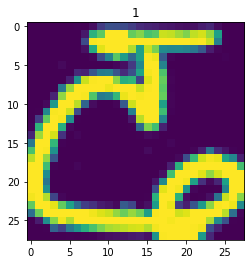

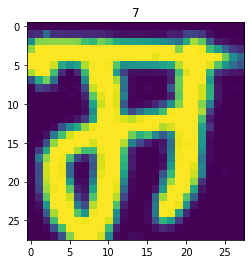

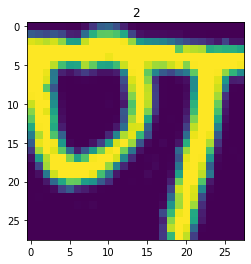

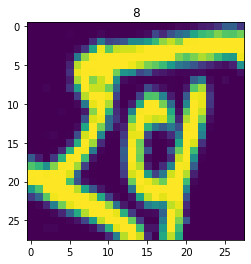

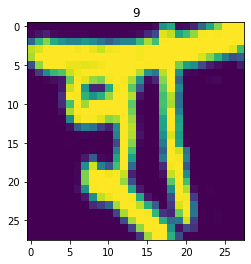

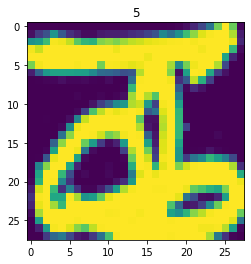

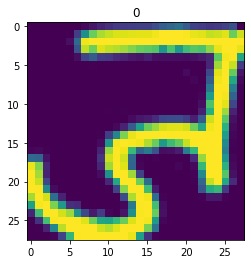

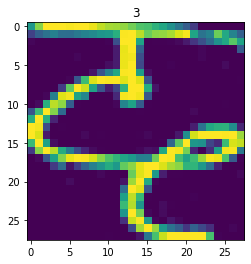

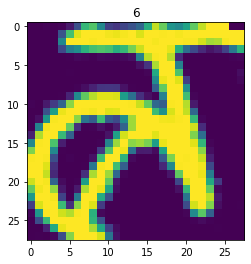

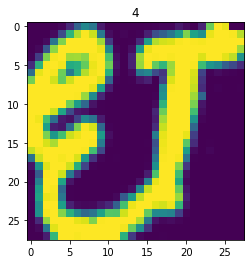

<IPython.core.display.Javascript object>

In [8]:
for i in range(0, 10000, 1000):
    plt.imshow(char_img_inter[i])
    plt.title(char_class[i])
    plt.show()

## Functions used to Augument the Training Data

* __Image Blurring__
* __Image Random Rotation__
* __Image Random Shifting__
* __Image Shearing__

In [9]:
# Function to blur the image
def blur_image(image, kernel):
    return cv2.GaussianBlur(image, (kernel, kernel), 0)


# Function to rotate image randomly
def random_rot(image):
    angle = random.randint(-15, 15)
    while angle in range(-5, 6):
        angle = random.randint(-15, 15)
    return (255 * rotate(image, angle)).astype(np.uint8)


# Function to shift image center randomly
def random_shift_image(image):
    dx = random.randint(-6, 6)
    dy = random.randint(-6, 6)
    while dx == 0 and dy == 0:
        dx = random.randint(-6, 6)
        dy = random.randint(-6, 6)
    image = image.reshape((28, 28))
    return shift(image, [dy, dx], cval=0, mode="constant").astype(np.uint8)


# Function to shear image randomly
def shear_image(img):
    sh_tr = AffineTransform(shear=0.2)

    return (255 * warp(img, inverse_map=sh_tr)).astype(np.uint8)

<IPython.core.display.Javascript object>

## Augumenting the Training Data

In [10]:
char_img_blur_3 = np.array(
    [blur_image(i, 3) for i in char_img_inter]
)  # Kernel Size = 3
char_img_blur_5 = np.array(
    [blur_image(i, 5) for i in char_img_inter]
)  # Kernel Size = 5

char_img_rot = np.array(
    [random_rot(i) for i in char_img_inter]
)  # Random Rotation on unblurred
char_img_shift = np.array(
    [random_shift_image(i) for i in char_img_inter]
)  # Random Shift on unblurred
char_img_shear = np.array(
    [shear_image(i) for i in char_img_inter]
)  # Random Shear on unblurred


char_img_rot_3 = np.array(
    [random_rot(i) for i in char_img_blur_3]
)  # Random Rotation on Kernel Size = 3
char_img_shift_3 = np.array(
    [random_shift_image(i) for i in char_img_blur_3]
)  # Random Shift on Kernel Size = 3
char_img_shear_3 = np.array(
    [shear_image(i) for i in char_img_blur_3]
)  # Random Shear on Kernel Size = 3

char_img_rot_5 = np.array(
    [random_rot(i) for i in char_img_blur_5]
)  # Random Rotation on Kernel Size = 5
char_img_shift_5 = np.array(
    [random_shift_image(i) for i in char_img_blur_5]
)  # Random Shift on Kernel Size = 5
char_img_shear_5 = np.array(
    [shear_image(i) for i in char_img_blur_5]
)  # Random Shear on Kernel Size = 5

<IPython.core.display.Javascript object>

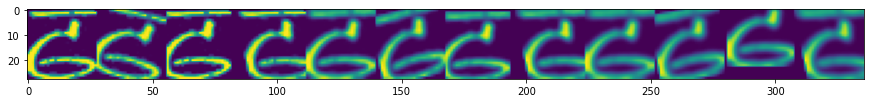

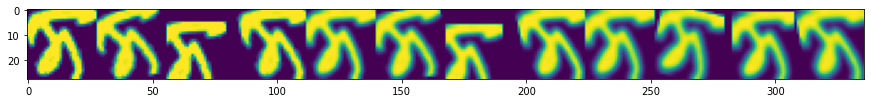

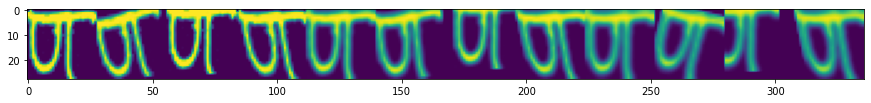

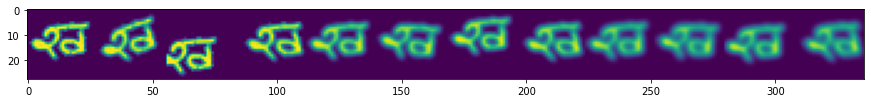

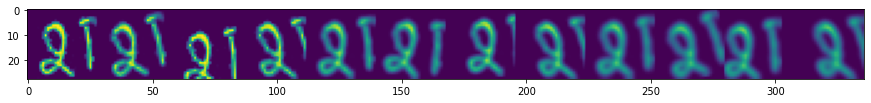

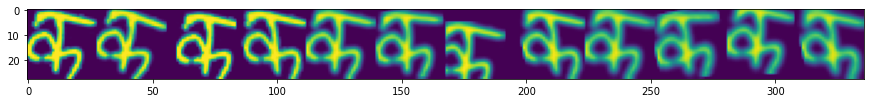

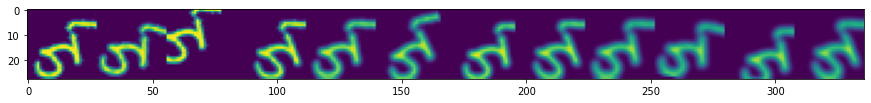

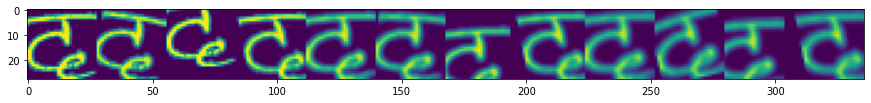

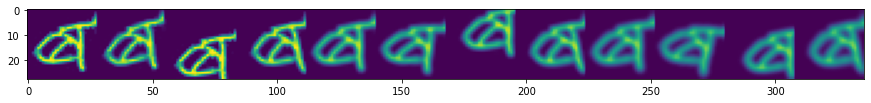

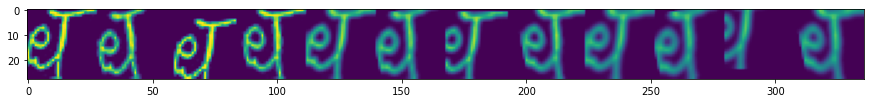

<IPython.core.display.Javascript object>

In [11]:
for i in range(0, 10000, 1000):
    f = random.randint(0, 1000)
    plt.figure(figsize=(15, 7))
    plt.imshow(
        np.hstack(
            [
                char_img_inter[i + f],
                char_img_rot[i + f],
                char_img_shift[i + f],
                char_img_shear[i + f],
                char_img_blur_3[i + f],
                char_img_rot_3[i + f],
                char_img_shift_3[i + f],
                char_img_shear_3[i + f],
                char_img_blur_5[i + f],
                char_img_rot_5[i + f],
                char_img_shift_5[i + f],
                char_img_shear_5[i + f],
            ]
        )
    )
    plt.show()

## Saving the Augumented Data

In [12]:
# Creating a new folder to store augumented data
!mkdir ./augumented_training_new

<IPython.core.display.Javascript object>

In [13]:
# Creating directories for each class
for i in range(10):
    os.mkdir("./augumented_training_new/character_" + str(i))

<IPython.core.display.Javascript object>

In [14]:
# Counter to keep count of number of images
counter = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}

# Loop to store all the images
for i in range(len(char_img)):
    cls = char_class[i]

    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_inter.csv",
        char_img_inter[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_rot.csv",
        char_img_rot[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shift.csv",
        char_img_shift[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shear.csv",
        char_img_shear[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )

    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_blur_3.csv",
        char_img_blur_3[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_rot_3.csv",
        char_img_rot_3[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shift_3.csv",
        char_img_shift_3[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shear_3.csv",
        char_img_shear_3[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )

    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_blur_5.csv",
        char_img_blur_5[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_rot_5.csv",
        char_img_rot_5[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shift_5.csv",
        char_img_shift_5[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )
    np.savetxt(
        "./augumented_training_new/character_"
        + str(cls)
        + "/"
        + str(counter[cls])
        + "_shear_5.csv",
        char_img_shear_5[i].astype(np.uint8),
        delimiter=",",
        fmt="%i",
    )

    counter[cls] += 1

<IPython.core.display.Javascript object>

In [15]:
# Checking the number of augumented training data in each class
for i in glob.glob("./augumented_training_new/character_*"):
    print(len(glob.glob(i + "/*.csv")))

12000
12000
12000
12000
12000
12000
12000
12000
12000
12000


<IPython.core.display.Javascript object>

# Part 2 - Training the Classification Model

## Loading the Augumented Data

In [16]:
# Placeholder for augumented training data
char_img = []
char_class = []

<IPython.core.display.Javascript object>

In [17]:
# List to store directories of all classes
characters = glob.glob("./augumented_training_new/character_*")

<IPython.core.display.Javascript object>

In [18]:
# Loop to read the training augumented data
for char in characters:
    char_type = int(char.split("_")[3])
    print("Reading character :", char_type)
    for i in glob.glob(char + "/*.csv"):
        data = pd.read_csv(i, header=None)
        char_img.append(data.values)
        char_class.append(char_type)

Reading character : 1
Reading character : 7
Reading character : 2
Reading character : 8
Reading character : 9
Reading character : 5
Reading character : 0
Reading character : 3
Reading character : 6
Reading character : 4


<IPython.core.display.Javascript object>

## Setting up data for training

### Shuffling the data

In [19]:
X, y = shuffle(np.array(char_img), np.array(char_class), random_state=10)

<IPython.core.display.Javascript object>

### Flattening the images

In [20]:
X_flattened = np.array([x.flatten() for x in X])

<IPython.core.display.Javascript object>

### Standardizing the images

In [23]:
sc = StandardScaler()
X_flattened_scaled = sc.fit_transform(X_flattened)

<IPython.core.display.Javascript object>

### Reducing the dimensionality of data using PCA

In [24]:
pca_percentage = PCA(n_components=0.99, svd_solver="full")
X_percentage = pca_percentage.fit_transform(X_flattened_scaled)

<IPython.core.display.Javascript object>

## Training the SVM model

In [25]:
clf_final = SVC(C=3, cache_size=1000)

<IPython.core.display.Javascript object>

In [26]:
clf_final.fit(X_percentage, y)

SVC(C=3, break_ties=False, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<IPython.core.display.Javascript object>

In [27]:
pickle.dump(sc, open("sc.sav", "wb"))
pickle.dump(pca_percentage, open("pca.sav", "wb"))
pickle.dump(clf_final, open("clf.sav", "wb"))

<IPython.core.display.Javascript object>

# Part 3 - Predicting on Test Data

> Please note that this is only a part of process for generating the final predictions. We have trained 5 models for ensembling whose prediction code is present in the next section. Note that the difference in the models arises due to the random function used while augumenting the data for the model.

In [28]:
kaggle_test_list = []

<IPython.core.display.Javascript object>

In [30]:
kaggle_df = pd.read_csv("./public_test.csv", header=None)

<IPython.core.display.Javascript object>

### We observed that the test images in Kaggle were incorrectly oriented while reshaping, hence we to realign the images to match with the training data alignment

In [31]:
for i in kaggle_df.T.values:
    reshaped_i = i.reshape((28, 28))
    kaggle_test_list.append(reshaped_i.T)

<IPython.core.display.Javascript object>

### Displaying a realigned Kaggle test image

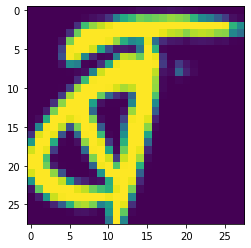

<IPython.core.display.Javascript object>

In [32]:
plt.imshow(kaggle_test_list[0])

In [33]:
# Flattening the Kaggle test images

kaggle_test_list_flattened = np.array([i.flatten() for i in kaggle_test_list])

# Scaling the Kaggle test images

kaggle_test_list_flattened_scaled = sc.transform(kaggle_test_list_flattened)

# Applying PCA on the Kaggle test set

kaggle_test_list_flattened_scaled_reduced = pca_percentage.transform(
    kaggle_test_list_flattened_scaled
)

kaggle_test_list_flattened_scaled_reduced.shape

# Using the trained model to predict the classes for Kaggle test set

y_pred_test_kaggle = clf_final.predict(kaggle_test_list_flattened_scaled_reduced)

# Generating the out.csv file for submission

kaggle_list = ["Sample_" + str(i) for i in range(1, 1001)]

out = pd.DataFrame({"Id": kaggle_list, "Expected": y_pred_test_kaggle})

out.head()

out.to_csv("out.csv", index=False)

<IPython.core.display.Javascript object>

# Function to predict on Private Dataset
> Note : Prediction takes a while due to the size of the models

In [15]:
def predict_private_dataset():
    # Initializing the number of models
    num_models = 5
    
    # Placeholder for test data
    kaggle_test_list = []
    
    # Reading the test data
    kaggle_df = pd.read_csv("./private_test.csv", header=None)
    
    # Reshaping the test data
    for i in kaggle_df.T.values:
        reshaped_i = i.reshape((28, 28))
        kaggle_test_list.append(reshaped_i.T)
    
    # Flattening the test data
    kaggle_test_list_flattened = np.array([i.flatten() for i in kaggle_test_list])
    results_df = pd.DataFrame()

    # Predicting using the trained models
    for i in range(num_models):
        main_path = "./models/"
        
        # Loading the scaling object
        sc_path = main_path + str(i + 1) + "/sc_" + str(i + 1) + ".sav"
        sc = pickle.load(open(sc_path, "rb"))
        # Scaling the data
        kaggle_test_list_flattened_scaled = sc.transform(kaggle_test_list_flattened)
        
        # Loading the PCA object
        pca_path = main_path + str(i + 1) + "/pca_" + str(i + 1) + ".sav"
        pca_percentage = pickle.load(open(pca_path, "rb"))
        # Applying PCA on the scaled data
        kaggle_test_list_flattened_scaled_reduced = pca_percentage.transform(
            kaggle_test_list_flattened_scaled
        )
        
        # Loading the model
        clf_path = main_path + str(i + 1) + "/clf_" + str(i + 1) + ".sav"
        clf_final = pickle.load(open(clf_path, "rb"))
        
        # Predicting on the test data
        y_pred_test_kaggle = clf_final.predict(kaggle_test_list_flattened_scaled_reduced)
        
        # Adding the results of the current model to the results dataframe
        results_df[i] = y_pred_test_kaggle
        
    # Applying mode operation to get the final prediction
    final_prediction, _ = mode(results_df.values, axis=1)
    
    return final_prediction.astype(int)

In [16]:
predicted_class = predict_private_dataset()